In [60]:
import pandas as pd
df = pd.read_csv(r'C:\Users\MAHADEV\OneDrive\Desktop\Zeel\Data Science\Tops\Fair work\Work\Machine Learning\Unsupervise ML\customer_segmentation.csv')

# Convert and engineer features
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')

df['Years_Customer'] = (pd.Timestamp('now').year) - df['Dt_Customer'].dt.year  

# Compute age
df['Age'] = pd.Timestamp('now').year - df['Year_Birth']  

# Total expense and campaigns accepted
spend_cols = ['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']
df['Total_Spend'] = df[spend_cols].sum(axis=1)
promo_cols = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response']
df['Total_Promos'] = df[promo_cols].sum(axis=1) 

### Data Preprocessing

In [66]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

for col in ['Education','Marital_Status']:
    df[col] = LabelEncoder().fit_transform(df[col])

features = ['Income','Recency','Years_Customer','Age',
            'Total_Spend','Total_Promos','NumDealsPurchases',
            'NumWebPurchases','NumCatalogPurchases','NumStorePurchases',
            'NumWebVisitsMonth']
X = df[features].copy()

X = StandardScaler().fit_transform(X)
import numpy as np



imputer = SimpleImputer(strategy='mean')  # or 'median'
X = imputer.fit_transform(X)


In [67]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3).fit_transform(X)


### K-means Clustering

#### Finding Optimal Number of Clusters

In [68]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Choose k using elbow and silhouette methods
wcss = [KMeans(n_clusters=k, random_state=42).fit(X).inertia_ for k in range(2,7)]
sil_scores = [silhouette_score(X, KMeans(n_clusters=k, random_state=42).fit_predict(X)) for k in range(2,7)]
# Typical choices are k=2–4 :contentReference[oaicite:8]{index=8}

kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
df['KMeans_Label'] = kmeans.labels_


In [69]:
df.groupby('KMeans_Label')[features].mean()


,Income,Recency,Years_Customer,Age,Total_Spend,Total_Promos,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
KMeans_Label,,,,,,,,,,,
0,34550.778112,49.064420,11.838454,53.562934,94.102081,0.166501,1.867195,2.030723,0.550050,3.217047,6.333994
1,76421.650514,49.940233,11.909621,57.533528,1289.408163,0.934402,1.342566,5.075802,5.724490,8.386297,2.886297
2,54404.805195,48.146789,12.297248,59.379817,692.669725,0.352294,4.409174,6.640367,2.717431,7.286239,6.491743


### Hierarchical Clustering

In [70]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3, linkage='average').fit(X)
df['Agg_Label'] = agg.labels_


In [71]:
df['KMeans_Label'].value_counts(), df['Agg_Label'].value_counts()


(KMeans_Label
 0    1009
 1     686
 2     545
 Name: count, dtype: int64,
 Agg_Label
 0    2235
 2       4
 1       1
 Name: count, dtype: int64)

In [72]:
pd.crosstab(df['KMeans_Label'], df['Agg_Label'])


Agg_Label,0,1,2
KMeans_Label,,,
0,1009,0,0
1,682,1,3
2,544,0,1


In [73]:
silhouette_score(X, df['KMeans_Label']), silhouette_score(X, df['Agg_Label'])


(np.float64(0.22616374337948977), np.float64(0.6280891394262205))

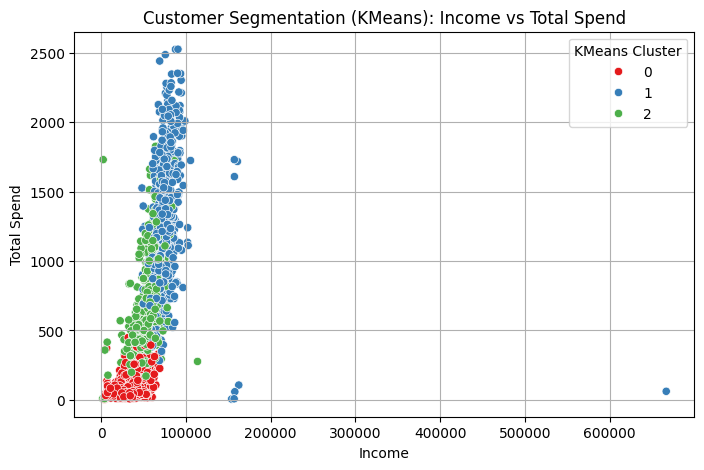

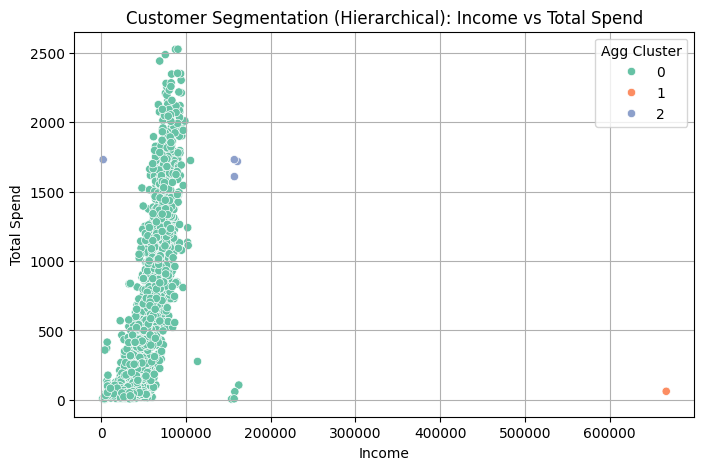

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Income vs Total_Spend colored by KMeans
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Income', y='Total_Spend', hue='KMeans_Label', palette='Set1')
plt.title("Customer Segmentation (KMeans): Income vs Total Spend")
plt.xlabel("Income")
plt.ylabel("Total Spend")
plt.legend(title='KMeans Cluster')
plt.grid(True)
plt.show()

# Income vs Total_Spend colored by Agglomerative Clustering
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Income', y='Total_Spend', hue='Agg_Label', palette='Set2')
plt.title("Customer Segmentation (Hierarchical): Income vs Total Spend")
plt.xlabel("Income")
plt.ylabel("Total Spend")
plt.legend(title='Agg Cluster')
plt.grid(True)
plt.show()


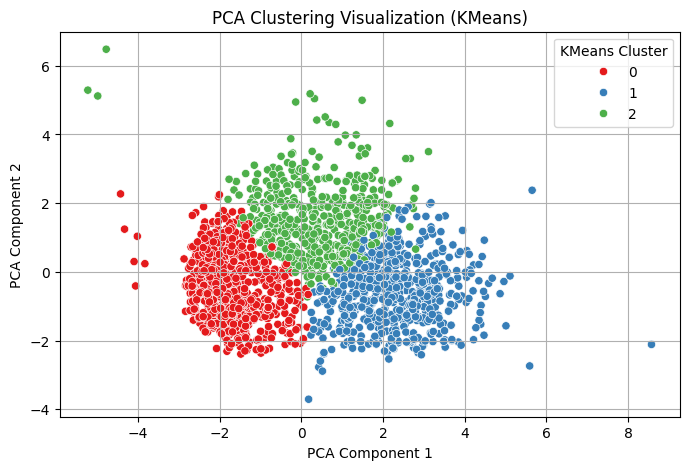

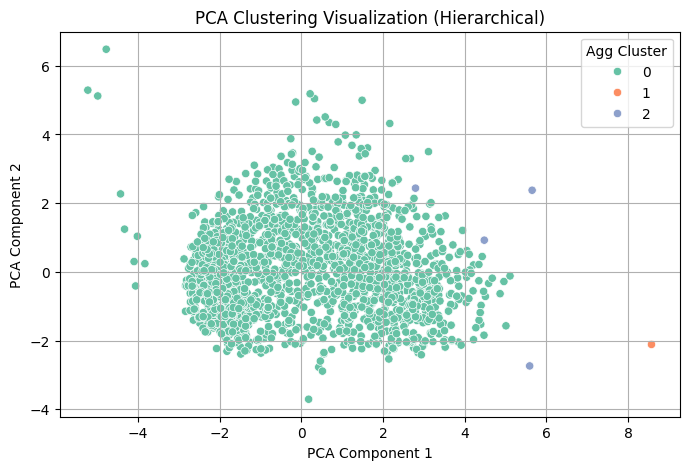

In [76]:
# X_pca has 3 PCA components
df['PCA1'] = pca[:, 0]
df['PCA2'] = pca[:, 1]

# PCA plot colored by KMeans
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='KMeans_Label', palette='Set1')
plt.title("PCA Clustering Visualization (KMeans)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='KMeans Cluster')
plt.grid(True)
plt.show()

# PCA plot colored by Agglomerative clustering
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Agg_Label', palette='Set2')
plt.title("PCA Clustering Visualization (Hierarchical)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Agg Cluster')
plt.grid(True)
plt.show()


In [78]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# For KMeans clustering
kmeans_labels = df['KMeans_Label']
print("Silhouette Score (KMeans):", silhouette_score(X, kmeans_labels))
print("Davies-Bouldin Score (KMeans):", davies_bouldin_score(X, kmeans_labels))
print("Calinski-Harabasz Score (KMeans):", calinski_harabasz_score(X, kmeans_labels))

print()

# For Agglomerative clustering
agg_labels = df['Agg_Label']
print("Silhouette Score (Hierarchical):", silhouette_score(X, agg_labels))
print("Davies-Bouldin Score (Hierarchical):", davies_bouldin_score(X, agg_labels))
print("Calinski-Harabasz Score (Hierarchical):", calinski_harabasz_score(X, agg_labels))


Silhouette Score (KMeans): 0.22616374337948977
Davies-Bouldin Score (KMeans): 1.7816340737558305
Calinski-Harabasz Score (KMeans): 616.006165009797

Silhouette Score (Hierarchical): 0.6280891394262205
Davies-Bouldin Score (Hierarchical): 0.5509773577942733
Calinski-Harabasz Score (Hierarchical): 49.05419269274571
